In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from matplotlib.ticker import ScalarFormatter
plt.rcParams['svg.fonttype'] = 'none'

# RNA Nanocage (ROOL and GOLLD) DLS

In [3]:
def plot_DLS_data(sample,outliers=[],plot_type="all",
                 concentrations = [0.5, 0.25, 0.125, 0.0625, 0.03125],
                 num_reps = 2, num_aqs = 10,
                 folder='Export_2024-04-19_09-26-36',
                 temperatures = [15,25,35,40,45,50,55,60,65,75],
                 ax=None,legend=True,
                 vmax=15,
                 multi_folder=True,
                 by_temp=True,
                 aq_offset=0,
                 rep_offset=None,
                 skip_T=[],
                 normalize=False):
    # temperatures in C

    # read in all data
    df = []
    temp_index = 0
    for conc in concentrations:
        for Tn in range(1,len(temperatures)+1+len(skip_T)):
            if not Tn in skip_T:
                if rep_offset is not None and Tn==rep_offset[0]:
                    rep_start = 1+rep_offset[1]
                    rep_end = num_reps+1+rep_offset[1]
                else:
                    rep_start = 1
                    rep_end = num_reps+1
                for rep in range(rep_start,rep_end):
                    for aq in range(1+aq_offset,num_aqs+1+aq_offset):
                        if (conc,temperatures[temp_index],rep,aq) not in outliers:
                            try:
                                if multi_folder:
                                    temp = pd.read_excel(f'{folder}/{sample}_{conc}_HEPES + MgCl2 ({Tn})/Replicate {rep}/Acquisition {aq}/{sample}_{conc}_HEPES + MgCl2 ({Tn}) - {rep}.xlsx')
                                else:
                                    temp = pd.read_excel(f'{folder}/{sample}_{conc}_HEPES + MgCl2/Replicate {rep}/Acquisition {aq}/{sample}_{conc}_HEPES + MgCl2 - {rep}.xlsx')
                            except:
                                if multi_folder:
                                    temp = pd.read_excel(f'{folder}/{sample}_{conc}_Hepes + MgCl2 ({Tn})/Replicate {rep}/Acquisition {aq}/{sample}_{conc}_Hepes + MgCl2 ({Tn}) - {rep}.xlsx')
                                else:
                                    temp = pd.read_excel(f'{folder}/{sample}_{conc}_Hepes + MgCl2/Replicate {rep}/Acquisition {aq}/{sample}_{conc}_Hepes + MgCl2 - {rep}.xlsx')

                            temp['sample'] = sample
                            temp['concentration'] = conc
                            temp['temperature'] = temperatures[temp_index]
                            
                            temp['replicate'] = rep
                            temp['acquisition'] = aq
                            temp['normalized_frequency']= temp['Relative frequency [%]']/temp['Relative frequency [%]'].sum()
                            df.append(temp)
                temp_index += 1
    df = pd.concat(df)
    

    if plot_type == "all":
        g = sns.relplot(kind="line",data=df, x="Radius [nm]", y= "Relative frequency [%]", 
                hue = "temperature",row="concentration",
                palette = "plasma_r",
                errorbar = ("ci",95), err_style="bars",
                err_kws = {'capsize':0.3,'elinewidth':0.1},
                height=2,aspect=3)
        # err_style="band", err_kws = {'alpha':0.1,'linewidth':0}
        # style="replicate 
        for ax, in g.axes:
            ax.set_xlim(df['Radius [nm]'].min(),df['Radius [nm]'].max())
            ax.set_xscale('log')
            ax.set_ylim(0,vmax)
    elif plot_type == "none":
        return df
    elif plot_type == "gel-like":
        if ax is None:
            fig, axes = plt.subplots(len(concentrations),sharex=True, figsize=(2,2*len(concentrations)))
        else:
            axes=[ax]

        radise_val_log10 = np.log10(df["Radius [nm]"].unique())
        #tick_values = np.array([0.6,0.7,0.8,0.9]+list(range(1,10,1))+list(range(10,100,10))+list(range(100,1000,100))+list(range(1000,9000,1000)))
        tick_values = np.array([1,10,100,1000,10000])
        radise_val_log10_to_index = np.polyfit(radise_val_log10,np.arange(len(radise_val_log10)),1)
        p = np.poly1d(radise_val_log10_to_index)
        tick_loc = 0.5+p(np.log10(tick_values))

        minor_tick_values = np.array([2,3,4,5,6,7,8,9,
                                      20,30,40,50,60,70,80,90,
                                      200,300,400,500,600,700,800,900,
                                     2000,3000,4000,5000,6000,7000,8000,9000])
        minor_tick_loc = 0.5+p(np.log10(minor_tick_values))

        for conc,df_conc in df.groupby("concentration"):
            i = concentrations[::-1].index(conc)
            if folder=='Export_2024-04-19_09-26-36':
                missed_T = [20,30,70]
                for T in missed_T:
                    df_conc = pd.concat([pd.DataFrame([[df_conc["Radius [nm]"].min(),0,'dummy',conc,T,1,1]], columns=df_conc.columns), df_conc], ignore_index=True)
            if by_temp:
                if normalize:
                    piv = pd.pivot_table(df_conc, values="normalized_frequency", index="Radius [nm]", columns="temperature", aggfunc='mean', sort=True)

                else:
                    piv = pd.pivot_table(df_conc, values="Relative frequency [%]", index="Radius [nm]", columns="temperature", aggfunc='mean', sort=True)
            else:
                #acquisition and replicate
                df_conc['acrep'] = df_conc.acquisition.astype(str) + df_conc.replicate.astype(str)
                if normalize:
                    piv = pd.pivot_table(df_conc, values="normalized_frequency", index="Radius [nm]", columns="acrep", aggfunc='mean', sort=True)
                else:
                    piv = pd.pivot_table(df_conc, values="Relative frequency [%]", index="Radius [nm]", columns="acrep", aggfunc='mean', sort=True)
            sns.heatmap(piv,ax=axes[i],cmap="Greys",cbar=legend,vmin=0,vmax=vmax)
            if i != 4:
                axes[i].set_xlabel("")
            axes[i].minorticks_on()
            axes[i].set_yticks(tick_loc,tick_values)
            axes[i].set_yticks(minor_tick_loc,minor=True)
            axes[i].set_xticks([],minor=True)
            if len(sample)<16:
                sample_name = sample
            else:
                sample_name = "\n".join(sample.split("_"))
            axes[i].set_title(f'{sample_name}\n{conc}mg/ml')
            axes[i].invert_yaxis()

    #return df

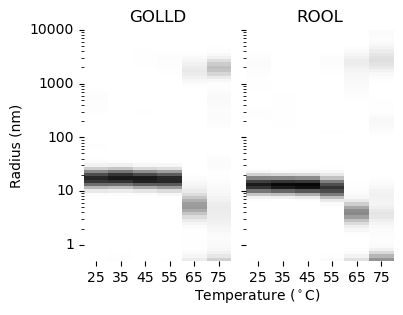

In [7]:
fig,axes = plt.subplots(1,2,figsize=(4,3),sharey=True)


plot_DLS_data('GOLLDa_Full',concentrations=[0.03],temperatures = [25,35,45,55,65,75],
              folder='DLS_data/GOLLDa-Export_2024-03-09_18-20-01',
              plot_type="gel-like",ax=axes[0],
                     legend=False,vmax=0.2,normalize=True)
plot_DLS_data('ROOL_120',concentrations=[0.03],temperatures = [25,35,45,55,65,75],
              folder='DLS_data/ROOL120_Export_2024-03-09_18-05-01',
              plot_type="gel-like",ax=axes[1],
                     legend=False,vmax=0.2,normalize=True)
axes[1].set_title('ROOL')
axes[0].set_title('GOLLD')
axes[1].set_ylabel('')
axes[0].set_ylabel('Radius (nm)')
axes[0].text(4.5,-12,'Temperature ($^\circ$C)')
plt.subplots_adjust(wspace=0.1) 
plt.savefig('cage_DLS.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('cage_DLS.png',dpi=400, bbox_inches="tight", transparent=True)